In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivlimathur","key":"49fd37b755b28d9f4b28ebb623b03ab1"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:12<00:00, 58.8MB/s]
100% 1.14G/1.14G [00:12<00:00, 94.8MB/s]


In [5]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [6]:
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
#Define Directories for train, test & Validation Set
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16
#The dimension of the images we are going to define is 500x500
img_height = 500
img_width = 500

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [8]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


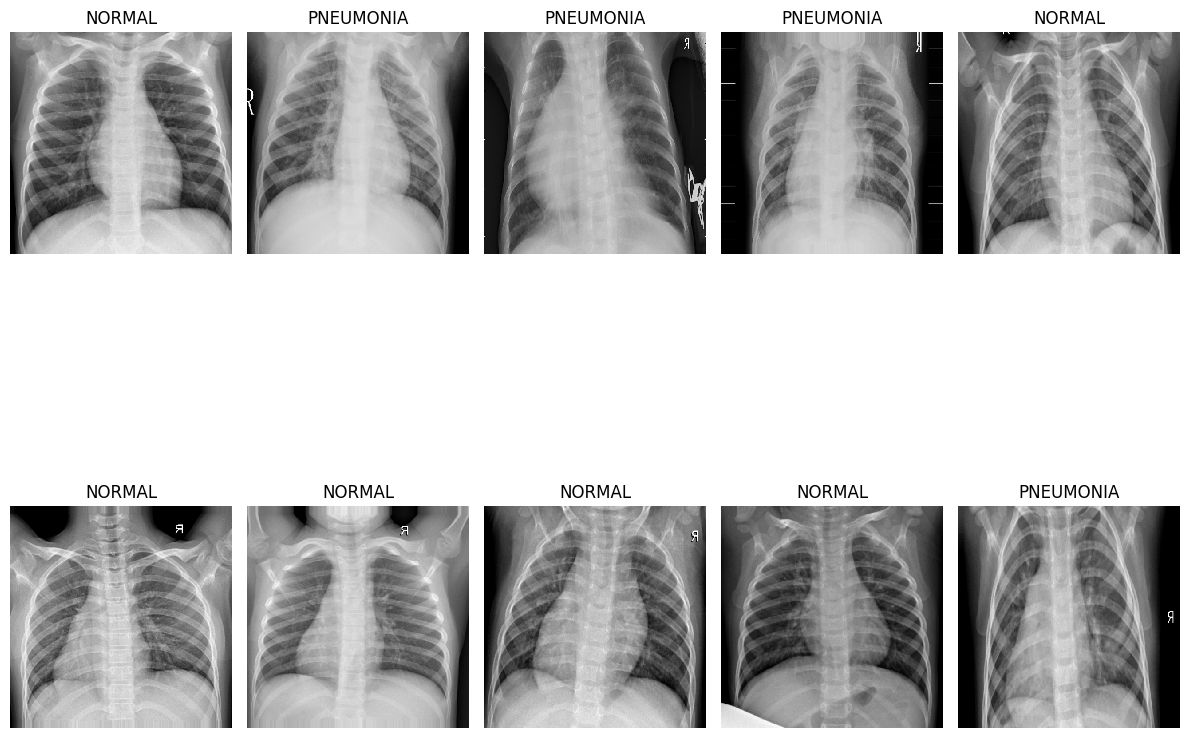

In [9]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [11]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 32)        0

In [13]:
# Hyperparameters of Conv2D
Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=(1, 1),
    padding="valid",
    activation=None,
    input_shape=(img_height,img_width,'grayscale')
    )
# Hyperparameters of MaxPooling2D
MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
    )

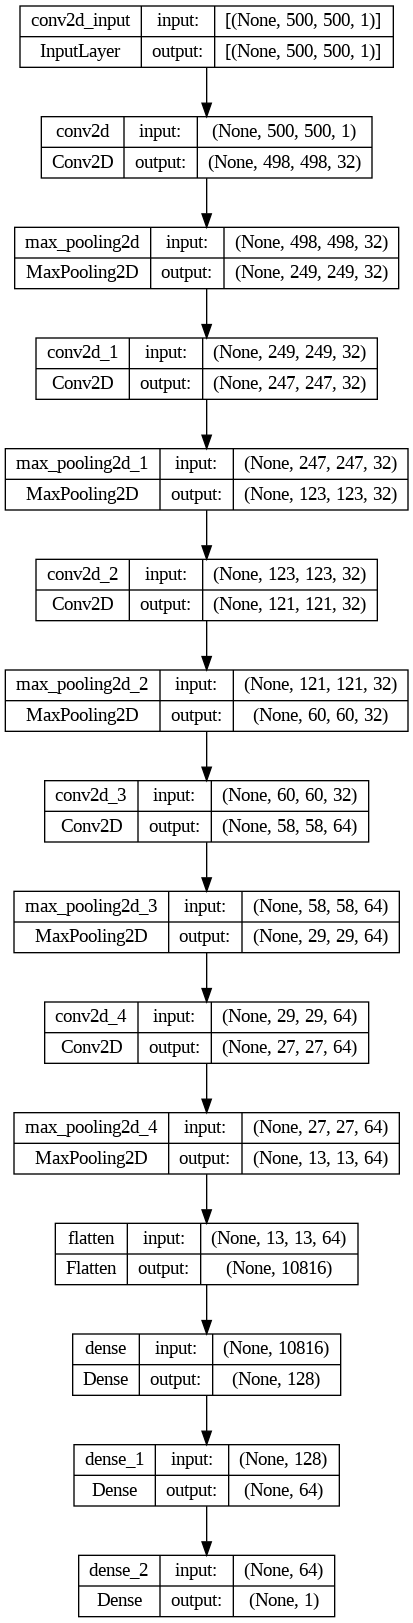

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [15]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [16]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [17]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
262/262 [==============================] - 127s 447ms/step - loss: 0.4185 - accuracy: 0.7736 - val_loss: 0.3325 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 2/25
262/262 [==============================] - 114s 436ms/step - loss: 0.2716 - accuracy: 0.8850 - val_loss: 0.2228 - val_accuracy: 0.9192 - lr: 0.0010
Epoch 3/25
262/262 [==============================] - 113s 431ms/step - loss: 0.2437 - accuracy: 0.9017 - val_loss: 0.2044 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 4/25
262/262 [==============================] - 117s 446ms/step - loss: 0.2075 - accuracy: 0.9160 - val_loss: 0.2299 - val_accuracy: 0.9096 - lr: 0.0010
Epoch 5/25
262/262 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9237
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
262/262 [==============================] - 113s 433ms/step - loss: 0.1883 - accuracy: 0.9237 - val_loss: 0.2380 - val_accuracy: 0.8990 - lr: 0.0010
Epoch 6/25
262/262 [========================

<Axes: >

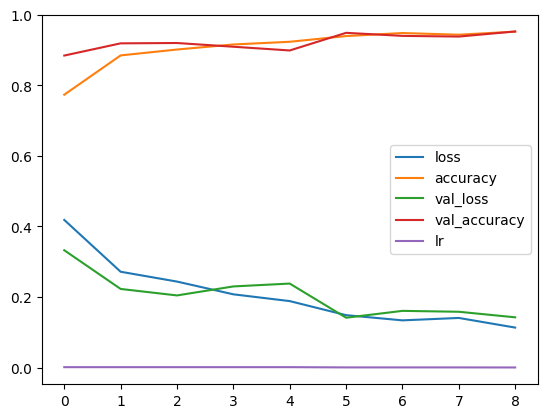

In [18]:
pd.DataFrame(cnn.history.history).plot()

In [19]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 4s 94ms/step - loss: 0.3267 - accuracy: 0.9119
The testing accuracy is : 91.18589758872986 %


In [20]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 4s 89ms/step


In [21]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

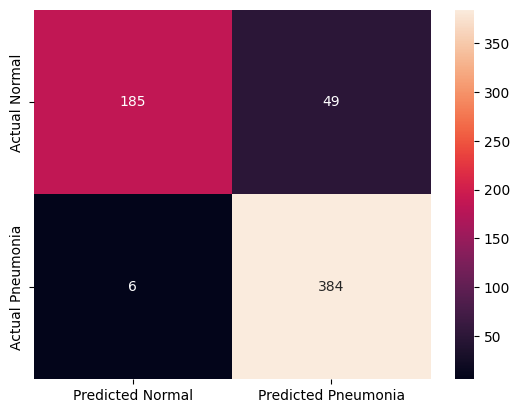

In [22]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [23]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.97      0.79      0.87       234
   PNEUMONIA       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



(624, 500, 500, 1)
(624,)


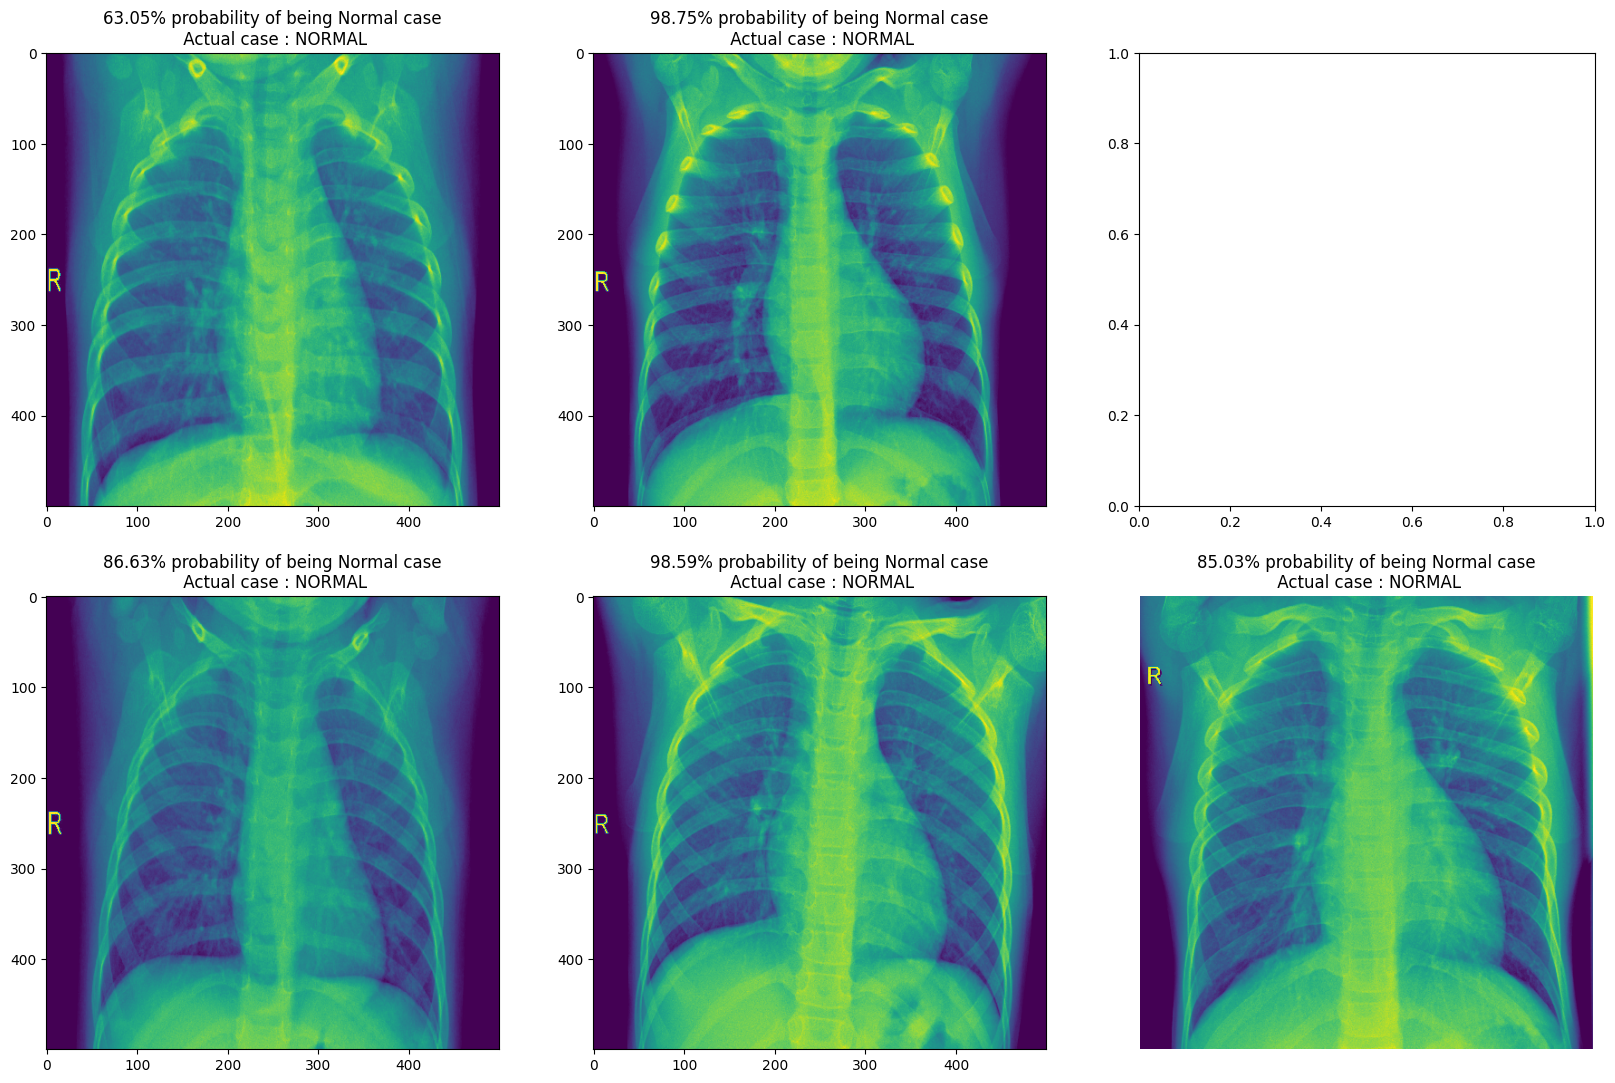

In [24]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 6+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5:
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))


  else:
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
      plt.title(out+"\n Actual case : "+ dic.get(y[i]))
      plt.imshow(np.squeeze(x[i]))
plt.axis('off')
plt.show()

1/1 [==============================] - 1s 1s/step


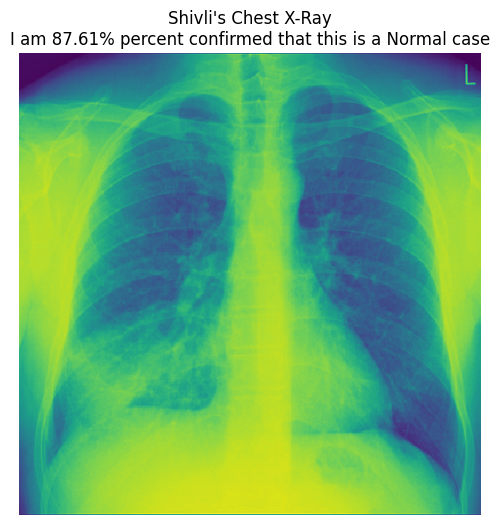

In [31]:
import os

shivli_path ='/0a1f5edc85aa58d5780928cb39b08659c1fc4d6d7c7dce2f8db1d63c7c737234_gallery.jpeg'

if os.path.exists(shivli_path):
    # Your existing code to load and process the image goes here
    shivli_img = image.load_img(shivli_path, target_size=(500, 500), color_mode='grayscale')
    pp_shivli_img = image.img_to_array(shivli_img)
    pp_shivli_img = pp_shivli_img/255
    pp_shivli_img = np.expand_dims(pp_shivli_img, axis=0)
#predict
    shivli_preds= cnn.predict(pp_shivli_img)

#print
    plt.figure(figsize=(6,6))
    plt.axis('off')
    if shivli_preds>= 0.5:
       out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(shivli_preds[0][0]))

    else:
       out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-shivli_preds[0][0]))
    plt.title("Shivli's Chest X-Ray\n"+out)
    plt.imshow(np.squeeze(pp_shivli_img))
    plt.show()
    # Rest of your code...
else:
    print(f"File not found: {shivli_path}")
